<center>
    <h1>
        Image Processing and Computer Vision
    </h1>
    <h2>
        Fruit inspection
    </h2>
</center>

<br>

<b>Student</b>: Matteo Donati <br>
<b>Registration no.</b>: 1032227 <br>
<b>E-mail</b>: matteo.donati10@studio.unibo.it

<br>

<hr>

In [1]:
# Importing cv2.
import cv2

# Importing numpy.
import numpy as np

# Importing pyplot.
from matplotlib import pyplot as plt

# Using TeX to render text.
plt.rc("text", usetex = True)

# Setting the pyplot font family.
plt.rc("font", family = "serif")

# Setting the pyplot font size.
plt.rcParams.update({"font.size": 15})

## First task

In [2]:
# Defining the filenames of gray-scale images.
gray_scale_filenames = ["C0\_000001", "C0\_000002", "C0\_000003"]

# Defining the filenames of colour images.
colour_filenames = ["C1\_000001", "C1\_000002", "C1\_000003"]

# Computing the number of images.
N_images = len(gray_scale_filenames)

# Defining the list containing gray-scale images.
gray_scale_images = []

# Defining the list containing colour images.
colour_images = []

# Reading the gray-scale images.
for i in range(N_images):
    
    # Reading the specific images.
    gray_scale_images.append(cv2.imread("images/first_task/{}.png".format(gray_scale_filenames[i].replace("\\", "")), cv2.IMREAD_GRAYSCALE))
    
    # Reading the specific images.
    colour_images.append(cv2.imread("images/first_task/{}.png".format(colour_filenames[i].replace("\\", ""))))
    
    # Converting the red image into RGB.
    colour_images[i] = cv2.cvtColor(colour_images[i], cv2.COLOR_BGR2RGB)

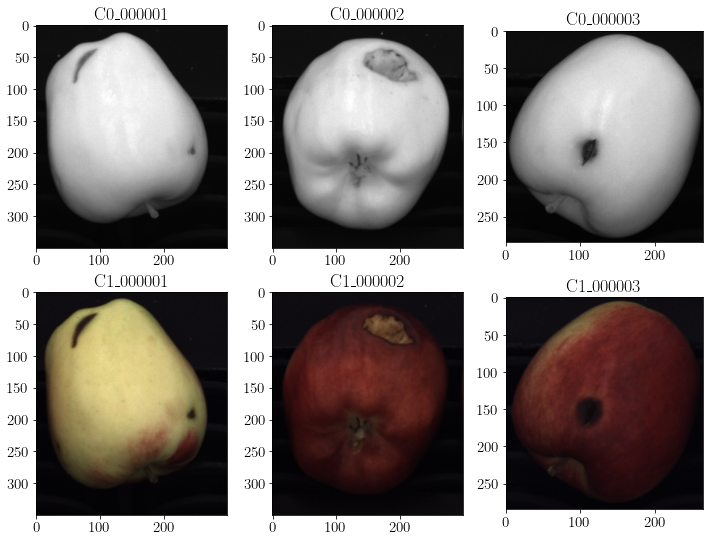

In [3]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (12, 9))

# Adding each gray-scale image to the figure.
for i in range(N_images):
    
    # Adding the specific title.
    ax[0, i].set_title(gray_scale_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    
    # Adding the specific title.
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[1, i].imshow(colour_images[i])

# Showing the figure.
plt.show()

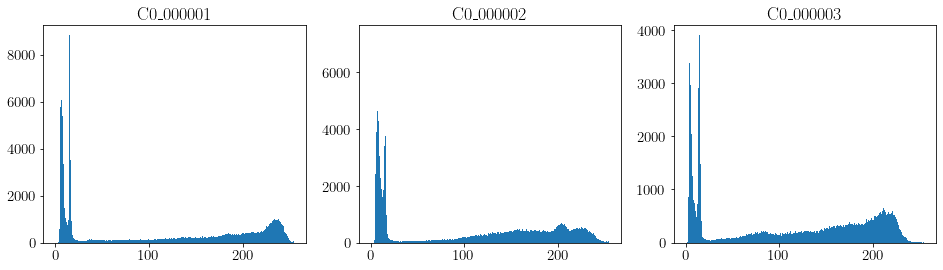

In [11]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (16, 4))

# Generating the intensity histogram related to the gray-scale images.
for i in range(N_images):
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Adding the histogram to the figure.
    ax[i].hist(gray_scale_images[i].flatten(), bins = range(256))

# Showing the figure.
plt.show()

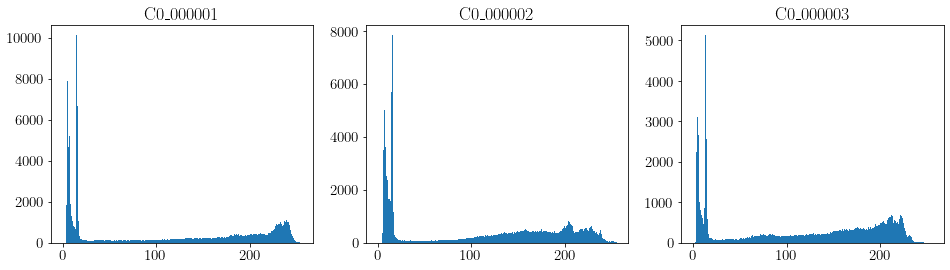

In [5]:
# List of the filtered gray-scale images.
f_gray_scale_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (16, 4))

# Filtering the images.
for i in range(N_images):
    
    # Appending the filtered image.
    f_gray_scale_images.append(cv2.bilateralFilter(gray_scale_images[i], 5, 75, 75))
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Adding the histogram of the smoothed image to the figure.
    ax[i].hist(f_gray_scale_images[i].flatten(), bins = range(256))

# Showing the figure.
plt.show()

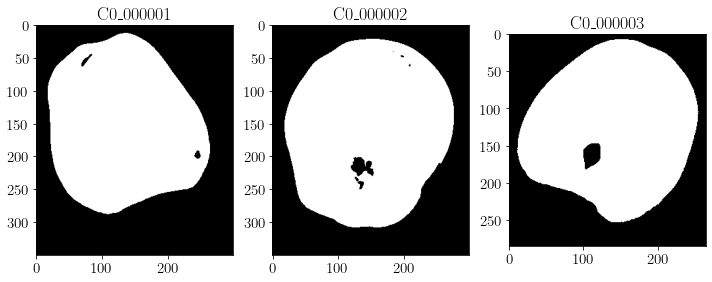

In [6]:
# List of masks.
threshold_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Thesholding the gray-scale images.
for i in range(N_images):
    
    # Applying Otsu's thresholding (https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html).
    threshold_value, binary_mask = cv2.threshold(f_gray_scale_images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Appending the generated binary mask.
    threshold_masks.append(binary_mask)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(threshold_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

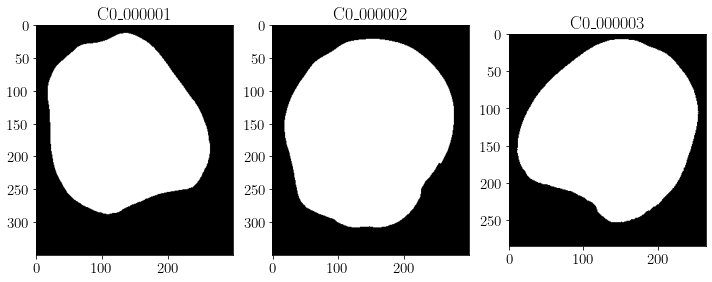

In [7]:
# List of masks.
fruit_masks = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Filling the holes of the already computed masks (https://learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/).
for i in range(N_images):
    
    # Copying masks[i].
    mask_copy = threshold_masks[i].copy()
    
    # Filling the holes inside the mask.
    cv2.floodFill(mask_copy, None, (0,0), 255)
    
    # Inverting the flood-filled image.
    inv = cv2.bitwise_not(mask_copy)
    
    # Adding the final mask by or-ing masks[i] and inv.
    fruit_masks.append(threshold_masks[i] | inv)
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(fruit_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

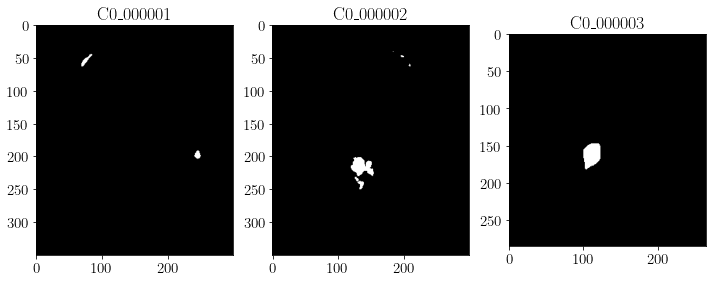

In [8]:
# Defining the figure object to be displayed.
fig, ax = plt.subplots(1, N_images, figsize = (12, 5))

# Showing the difference between the threshold masks and the fruit masks.
for i in range(N_images):
    
    # Adding the specific title.
    ax[i].set_title(gray_scale_filenames[i])
    
    # Plotting the computed binary mask.
    ax[i].imshow(threshold_masks[i] != fruit_masks[i], cmap = "gray")

# Showing the figure.
plt.show()

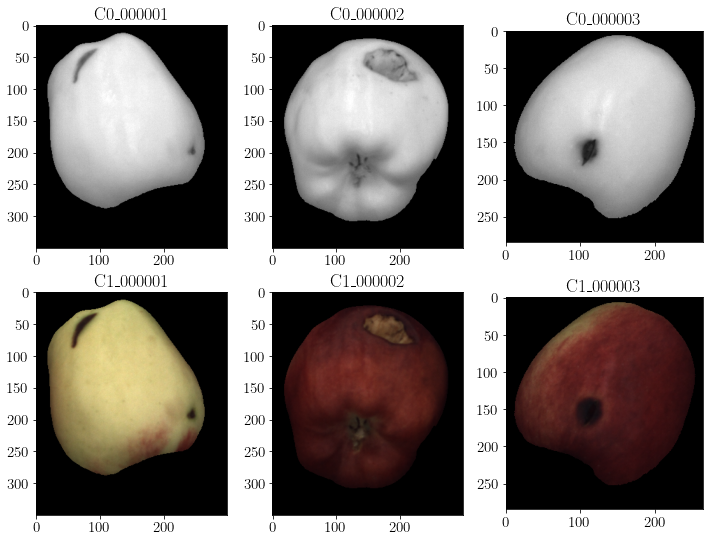

In [14]:
# List of masked gray-scale images.
m_gray_scale_images = []

# List of masked colour images.
m_colour_images = []

# Defining the figure object to be displayed.
fig, ax = plt.subplots(2, N_images, figsize = (12, 9))

# Applying the computed final masks to the original images.
for i in range(N_images):
    
    # Applying the computed mask to the specific gray-scale image.
    m_gray_scale_images.append(gray_scale_images[i] & fruit_masks[i])
    
    # Applying the computed mask to the specific colour image.
    m_colour_images.append(colour_images[i] & cv2.cvtColor(fruit_masks[i], cv2.COLOR_GRAY2BGR))
    
    # Adding the specific title.
    ax[0, i].set_title(gray_scale_filenames[i])
    
    # Adding the specific image to the figure.
    ax[0, i].imshow(m_gray_scale_images[i], cmap = "gray", vmin = 0, vmax = 255)
    
    # Adding the specific title.
    ax[1, i].set_title(colour_filenames[i])
    
    # Adding the specific image to the figure.
    ax[1, i].imshow(m_colour_images[i])

# Showing the figure.
plt.show()

## Second task

## Final challenge